# Overview

This notebook demonstrates how Singular Value Decomposition (SVD) can be used to compress high-dimensional optic flow data into a low-dimensional representation. This compression technique is crucial for making state estimation computationally tractable when using visual information.

**Topics covered:**

1. **Install and Import Packages** - Setup the computational environment
2. **Download and Load Optic Flow Data** - Access pre-generated training and test datasets
3. **SVD Compression** - Learn the theory and apply SVD to compress optic flow
4. **Validation on Test Data** - Verify that compression generalizes to new trajectories
5. **Exercises** - Explore compression limits and construct novel test cases
6. **Next steps** - Where we go next
7. **Tips for Constructing Novel Trajectories** - Guide for generating new test data for the Exercises

**Key learning objectives:**
- Understand how SVD reduces dimensionality while preserving information
- Learn to choose appropriate truncation ranks for compression
- Evaluate compression quality through reconstruction error
- Assess generalization to out-of-distribution data

# 1.&nbsp;Install and Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:

try:
    import nonlinear_estimation_utilities
    print('Package ' + 'nonlinear_estimation_utilities' + ' is already installed.')
    nonlinear_estimation_utilities.check_for_updates()
except:
    !pip install -qq git+https://github.com/florisvb/Nonlinear_and_Data_Driven_Estimation && echo "✓ nonlinear_estimation_utilities installed"
    import nonlinear_estimation_utilities
    nonlinear_estimation_utilities.check_for_updates()

  Preparing metadata (setup.py) ... done
✓ nonlinear_estimation_utilities installed
✓ You have the latest version (0.0.32)


In [10]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Install requirements

In [4]:
nonlinear_estimation_utilities.install_and_download_requirements.install_planar_drone_requirements()

Attempting to pip install: casadi
Attempting to pip install: do_mpc
Attempting to pip install: git+https://github.com/vanbreugel-lab/pybounds
Attempting to pip install: pynumdiff


## Load planar drone modules

In [26]:
nonlinear_estimation_utilities.load_planar_drone_modules()

planar_drone = nonlinear_estimation_utilities.planar_drone
generate_training_data_utility = nonlinear_estimation_utilities.generate_training_data_utility
terrain_and_optic_flow_utility  = nonlinear_estimation_utilities.terrain_and_optic_flow_utility

In [27]:
nonlinear_estimation_utilities.load_plotting_modules()

plot_tme = nonlinear_estimation_utilities.plot_utility.plot_tme

In [ ]:
import sys
import os
import requests
import numpy as np
import scipy
from scipy.ndimage import uniform_filter
import pandas as pd
import matplotlib.pyplot as plt
import copy

In [ ]:
try:
  import pynumdiff
except:
  !pip install pynumdiff
  import pynumdiff

try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.1 kB 4.3 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/usr/local/lib/python3.12/dist-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


  Cloning https://github.com/vanbreugel-lab/pybounds to /tmp/pip-req-build-khdvamqy
  Running command git clone --filter=blob:none --quiet https://github.com/vanbreugel-lab/pybounds /tmp/pip-req-build-khdvamqy
  Resolved https://github.com/vanbreugel-lab/pybounds to commit 96f12039ac9e1e3ef4381cd09a026f6bbf70ad5c
  Preparing metadata (setup.py) ... done
  Created wheel for pybounds: filename=pybounds-0.0.13-py3-none-any.whl size=19546 sha256=e5225f34fd1ebfb642fb6a24f9aa16db6a0d7628f73a955a68d171c4dc36607e
  Stored in directory: /tmp/pip-ephem-wheel-cache-_0diixba/wheels/cb/f8/fb/ff1887f9a2f35c3edad7b1acb7da69437c1fd8d885a800578d
Successfully built pybounds


In [ ]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

planar_drone = import_local_or_github('planar_drone', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')
generate_training_data_utility = import_local_or_github('generate_training_data_utility', directory='../Utility')
terrain_and_optic_flow_utility = import_local_or_github('terrain_and_optic_flow_utility', directory='../Utility')

Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>


# 2.&nbsp;Download and Load Optic Flow Data

We'll use a subset of trajectories generated in the previous notebook. The dataset contains optic flow measurements from many different drone trajectories over randomly generated terrain.

## Download the dataset

In [7]:
generate_training_data_utility.download_data('planar_drone_trajectories_opticflow_subset.zip')

Fetching from: https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Data/planar_drone_trajectories_opticflow_subset.zip
Successfully downloaded planar_drone_trajectories_opticflow_subset.zip (89339606 bytes)
unzipping...


In [8]:
directory = 'planar_drone_trajectories_opticflow_subset'
keyword = 'opticflows'
optic_flows = generate_training_data_utility.load_trajectory_data(directory, keyword)

Number of trajectories: 
300


## Create training and validation sets

We'll split the data into a training set (used to learn the SVD basis) and a validation/test set (used to verify that the compression generalizes to new trajectories).

In [11]:
# Merge the training set into a single dataframe
training_set = pd.concat(optic_flows[0:200], axis=0)

# Keep the test sets as individual trajectories
test_set = optic_flows[200:]

# 3.&nbsp;SVD Compression

## SVD Theory

Singular Value Decomposition factorizes a matrix $\Omega \in \mathbb{R}^{n \times m}$ into three matrices:

$$
\Omega = U \Sigma V^T
$$

where:
- $U \in \mathbb{R}^{n \times n}$ contains the left singular vectors (spatial modes)
- $\Sigma \in \mathbb{R}^{n \times m}$ is a diagonal matrix of singular values
- $V \in \mathbb{R}^{m \times m}$ contains the right singular vectors (temporal modes)

For compression, we truncate to rank $r \ll \min(n,m)$:

$$
\Omega \approx U_r \Sigma_r V_r^T
$$

This allows us to represent each snapshot (column of $\Omega$) using only $r$ coefficients instead of $n$ values, achieving compression ratio of $n/r$.

**For optic flow:** Each snapshot contains optic flow measurements from all rays at a single time instant. SVD learns the most common spatial patterns (modes) in the optic flow field.

## Prepare data for SVD

First, examine the shape of our training set. The dataframe has rows as snapshots (time instants).

In [12]:
training_set.shape

(18000, 209)

Standard data format for SVD has columns corresponding to snapshots of data, so we transpose relative to the dataframe format (which has rows as snapshots).

In [13]:
Omega = training_set.values.T
Omega.shape

(209, 18000)

## Perform the SVD

In [14]:
U, E, Vt = np.linalg.svd(Omega, full_matrices=False)

## Truncate to reduced rank

This can be done either via an "optimal" approach based on singular value distribution, or manually. Either way, it is helpful to visualize the distribution of singular values to understand the intrinsic rank of the data.

### Option 1: Choose the cutoff $r$ optimally

The optimal hard threshold for singular values can be determined based on the noise level in the data. See [Gavish & Donoho (2014)](https://ieeexplore.ieee.org/document/6846297) for details on this method.

rank:  52


Text(0, 0.5, 'Value of singular value')

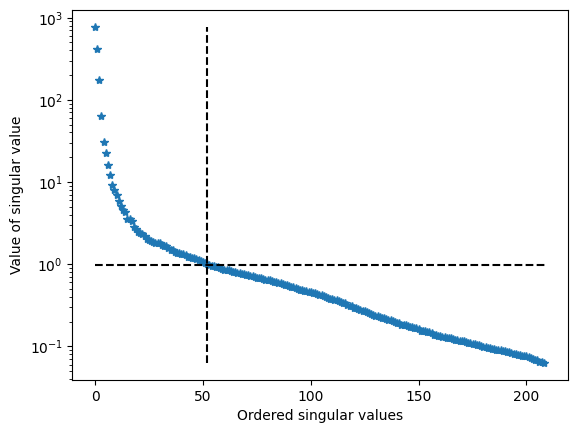

In [15]:
# optimal singular value cutoff
singvalthresh = 4/np.sqrt(3)*np.median(E)
r = np.where(E>singvalthresh)[0][-1]
print('rank: ', r)

plt.plot(E, '*')
plt.yscale('log')
plt.hlines(singvalthresh, 0, len(E), linestyles='--', color='black')
plt.vlines(r, np.min(E), np.max(E), linestyles='--', color='black')

plt.xlabel('Ordered singular values')
plt.ylabel('Value of singular value')

### Option 2: Choose $r$ manually (e.g., for more compression)

For more aggressive compression, we can manually select a smaller rank value.

In [16]:
r = 20

### Truncate with choice of rank

In [17]:
Ur = U[:,0:r]
Er = np.diag(E[0:r])
Vr = Vt.T[:,0:r]

### Visualize the SVD modes

The columns of $U_r$ form the basis vectors (modes). Each complete optic flow snapshot can be approximately reconstructed as a linear combination of these basis vectors.

Notice how the basis resembles a warped Fourier basis - the warping occurs because optic flow is more variable towards the edges of the field of view. The first two modes capture optic flow patterns for flat terrain with horizontal and vertical movement. Additional modes capture combinations of these flow patterns and provide the richness needed to model complex terrain.

Text(0, 0.5, 'Optic flow basis')

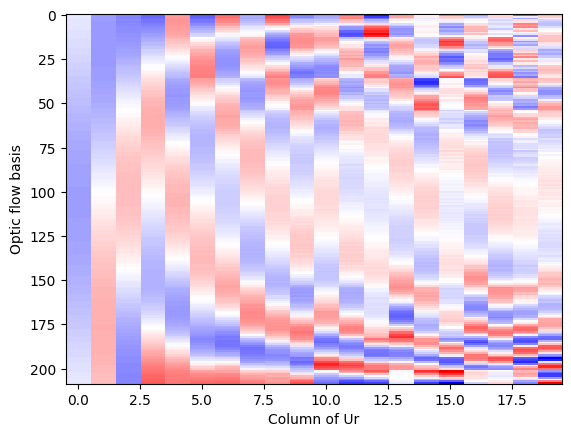

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(Ur, interpolation='nearest', cmap='seismic', vmin=-0.5, vmax=0.5)
ax.set_aspect('auto')

ax.set_xlabel('Column of Ur')
ax.set_ylabel('Optic flow basis')

## Example: Compress and reconstruct a single snapshot

Here we demonstrate compression and reconstruction for a single snapshot of optic flow from the training set.

### Extract one snapshot of optic flow

In [19]:
# Extract one snap shot of optic flow
y = Omega[:,10:11]

### Verify data dimensions

In [20]:
print(y.shape)
print(Ur.shape)

(209, 1)
(209, 20)


### Project into reduced-order basis

To project the original data into the reduced-order basis, we compute $\tilde{y} = U_r^T y$, where $y$ is the original high-dimensional snapshot and $\tilde{y}$ are the compressed coefficients.

In [21]:
# Project the snap shot into the reduced order basis
y_reduc = Ur.T@y

### Visualize the reduced-order projection

Text(0, 0.5, 'Basis coefficient value')

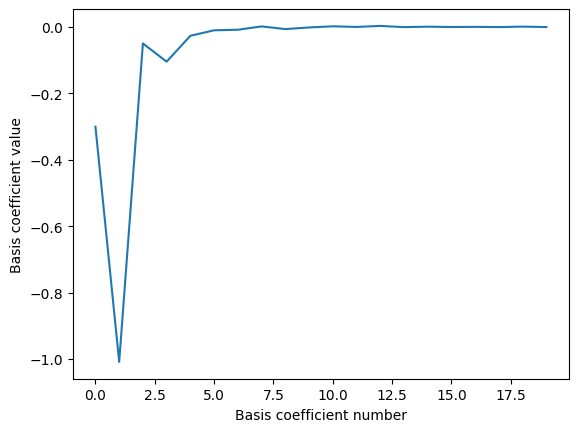

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(y_reduc)
ax.set_xlabel('Basis coefficient number')
ax.set_ylabel('Basis coefficient value')

### Reconstruct and compare

Reconstruct the full-dimensional signal from the compressed representation using $y_{recon} = U_r \tilde{y}$, and compare to the original signal. Notice how we capture the key features with far fewer values using only a linear transformation.

In [23]:
# Reconstruct the full dimension from the compressed y
y_recon = Ur@y_reduc

Text(0, 0.5, 'Optic flow value')

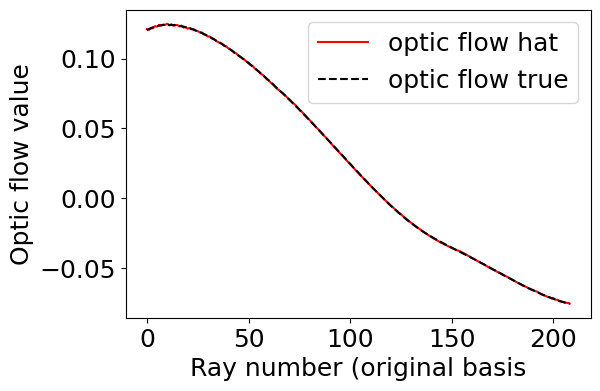

In [28]:
plot_tme(np.arange(0, len(y), 1), y, None, y_recon, label_var='optic flow')

plt.xlabel('Ray number (original basis')
plt.ylabel('Optic flow value')

# 4.&nbsp;Validation on Test Data

Now we verify that our SVD compression generalizes to trajectories that were not in the training set. This tests whether the learned basis captures the fundamental patterns of optic flow, or if it simply overfits to the training data.

In [29]:
trajec_optic_flow = test_set[0]

In [30]:
# Load, compress, and reconstruct the test data
test_Omega = trajec_optic_flow.values.T
test_data_reduc = Ur.T@test_Omega
test_data_recon = Ur@test_data_reduc

Text(0.5, 0, 'Time, pts')

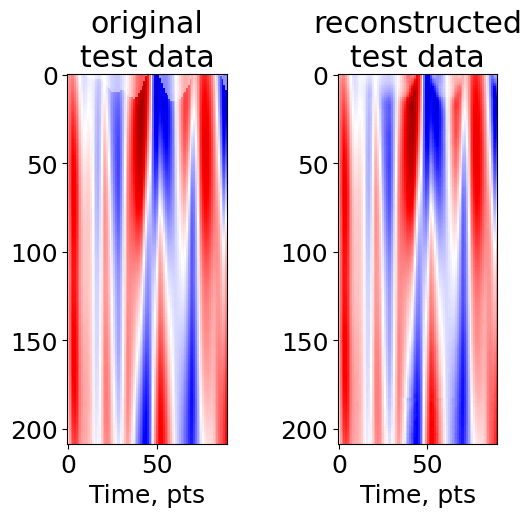

In [31]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title('original\ntest data')
ax1.imshow(test_Omega, interpolation='nearest', vmin=-0.5, vmax=0.5, cmap='seismic')
ax1.set_xlabel('Time, pts')

ax2.set_title('reconstructed\ntest data')
ax2.imshow(test_data_recon, interpolation='nearest', vmin=-0.5, vmax=0.5, cmap='seismic')
ax2.set_xlabel('Time, pts')

# 5.&nbsp;Exercises

1. **Explore truncation rank:** Change the truncation rank $r$. Plot the reconstruction error versus rank to find the optimal tradeoff.
    * Question: How small can you make it and still get a good reconstruction?

2. **Test generalization limits:** Construct an optic flow time series that is very different from the patterns in the training set. You can do this one of two ways:
    * Manually construct optic flow arbitrarily without regard for terrain or drone movement
    * Construct a new drone trajectory and terrain, then determine the corresponding optic flow (see tips in Section 7)
    * Question: Does the SVD compression generalize?   

#6.&nbsp;Next steps

1. Use the reduced order space to construct a ANN altitude estimator (Lesson 18)
2. Use the reduced order space to build data driven models (Left to the reader)

# 7.&nbsp;Tips for Constructing Novel Trajectories

The following sections show how to construct a completely new trajectory, terrain, and optic flow time series. The <mark>highlighted</mark> sections indicate where you need to make changes to generate novel data.

## Create a new trajectory

This first section needs no adjustment - it sets up the drone dynamics and measurement models.

In [33]:
import pybounds

In [34]:
# Planar drone dynamics and measurements
f = planar_drone.F(k=1).f
h = planar_drone.H('h_camera_imu', k=1).h

# Time step
dt = 0.1

# Set up the simulator
state_names = ['theta', 'theta_dot', 'x', 'x_dot', 'z', 'z_dot']
input_names = ['j1', 'j2']
measurement_names = h(None, None, return_measurement_names=True)

simulator = pybounds.Simulator(f, h, dt=dt, state_names=state_names,
                               input_names=input_names, measurement_names=measurement_names, mpc_horizon=10)


### Define novel setpoints

<mark>This is the part you should change</mark> to make the trajectory do something new and interesting. Note that the actual path will still be limited by the drone's dynamics - the MPC controller will handle that constraint automatically.

In [35]:
# First define the set-point(s) to follow
tsim = np.arange(0, 5.0, step=dt)
NA = np.zeros_like(tsim)
setpoint = {'theta': NA,
            'theta_dot': NA,
            'x': 1.0*np.cos(2*np.pi*tsim*0.3),  # <<<< Do something interesting here
            'x_dot': NA,
            'z': 0.3*np.sin(2*np.pi*tsim*0.2)+0.5, # <<<<<< Do something interesting here
            'z_dot': NA,
           }

### Run the MPC controller

Run the MPC to make the drone follow the setpoints. This section needs no adjustment.

In [36]:
# Update the simulator set-point
simulator.update_dict(setpoint, name='setpoint')

# Define MPC cost function: penalize the squared error between the setpoint for g and the true g
cost_x = (simulator.model.x['x'] - simulator.model.tvp['x_set']) ** 2
cost_z = (simulator.model.x['z'] - simulator.model.tvp['z_set']) ** 2
cost = cost_x + cost_z

# Set cost function
simulator.mpc.set_objective(mterm=cost, lterm=cost)  # objective function

# Set input penalty: make this small for accurate state tracking
simulator.mpc.set_rterm(j1=1e-4, j2=1e-4)

# Set some bounds
simulator.mpc.bounds['lower', '_x', 'theta'] = -np.pi/4
simulator.mpc.bounds['upper', '_x', 'theta'] = np.pi/4
simulator.mpc.bounds['lower', '_x', 'z'] = 0.0
simulator.mpc.bounds['lower', '_u', 'j2'] = 0.0

# Run simulation using MPC
t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=None, u=None, mpc=True, return_full_output=True)

### Package results into trajectory dataframe

Repackage the simulation results into a trajectory dataframe. This section needs no adjustment.

In [37]:
test_trajec = planar_drone.package_data_as_pandas_dataframe(t_sim, x_sim, u_sim, y_sim)

## Create a new terrain profile

<mark>Replace the terrain with something completely different from the training set.</mark>

**Hint:** You can get a sense of the training set terrain by visualizing terrain objects with different random seeds.

In [38]:
terrain = terrain_and_optic_flow_utility.Terrain(seed=1)

# terrain.terrain defines the elevation profile, you can change in this in place.
# If you do, then you need to run this function so that subsequent functions that use the terrain object have the up-to-date profile.
terrain.__update_curve_points__()

### Adjust trajectory altitude and visualize

Adjust the trajectory altitude to maintain clearance above the terrain, and visualize your terrain with the drone trajectory.

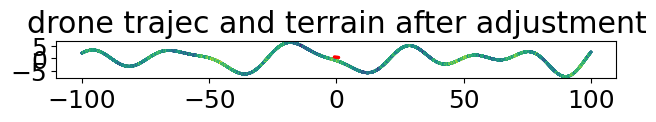

In [39]:
# adjust trajectory height
test_trajec_adj = terrain_and_optic_flow_utility.adjust_trajec_altitude(test_trajec, terrain, plot=True)

## Calculate optic flow for the new trajectory

Use the terrain and trajectory to compute the corresponding optic flow time series.

In [41]:
result = terrain_and_optic_flow_utility.get_imgs_and_analytic_optic_flows(test_trajec_adj, terrain)
imgs, optic_flows, ray_distances = result

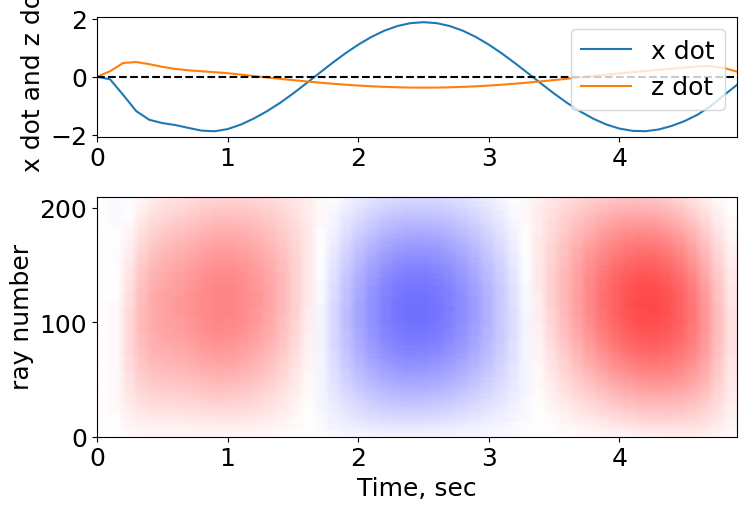

In [43]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_axes([0.2, 0.7, 0.8, 0.2])
ax2 = fig.add_axes([0.2, 0.2, 0.8, 0.4])

ax1.plot(test_trajec_adj.time.values, test_trajec_adj.x_dot.values, label='x dot')
ax1.plot(test_trajec_adj.time.values, test_trajec_adj.z_dot.values, label='z dot')
ax1.legend()
ax1.set_xlim([test_trajec_adj.time.values.min(), test_trajec_adj.time.values.max()])
ax1.hlines(0, test_trajec_adj.time.values.min(), test_trajec_adj.time.values.max(),
           linestyles='--', colors='black')
ax1.set_ylabel('x dot and z dot')

ax2.imshow(optic_flows, vmin=-5, vmax=5, cmap='seismic', extent=[test_trajec_adj.time.values.min(),
                                                                 test_trajec_adj.time.values.max(),
                                                                 0, 210])
ax2.set_ylabel('ray number')
ax2.set_xlabel('Time, sec')

ax2.set_aspect('auto')

## Compress and evaluate the novel optic flow

<mark>Use the same SVD compressor that was trained on the original training data.</mark> How does the reconstruction compare to the true value? How different is your trajectory and elevation profile from the training set? Does the compression still work well for out-of-distribution data?